# NP04 Analysis Template

Welcome to the NP04 Analysis Scripts

Dummy values (10000 and -10000) have been assigned to all variables which students would typically change. 

However, don't be scared of the code and play around with it - This is an experimental lab after all...

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

FileName = 'runD_991003.dat'

### Notes about the structure of the data:

Each line in the file represents the data from one trigger of the oscilloscope.  When it triggers, data are collected for some ticks before to some ticks after the trigger time depending on the settings you used in the SDKprogram run. The timebase is on setting 2 (or setting 1) which is 4ns per tick (or 2 ns, but with only 8-bit ADC resolution).

The picoscope has a somewhat novel, and rather nice way of formatting the analogue-to-digital convesion values (ADC values).  The ADC values are always given in a 16-bit range, i.e. from -32768 to +32767 even if the ADC is set to a lower resolution, in which case the lower bits are zero and the ADC values jump by the appropriate power of 2 (for 12 bits, which is our usual, this is jumps of 16 (2^(16-12)).  This means that if we change the resolution, we don't have to rewrite the code.  The SDKprogram setting menu prints the ADC count and milliVolt ranges, and this is easiest way to get the conversion factor if you need it.

We suggest in the script to use channel B for the START PMT and channel A for the STOP PMT.  If you did it the other way round, this program can be easilly fixed.  The baseline on the channels are at 0 ADC counts and pulses are negative.  There is a hardware trigger (called 'cut 1' below) which results in an 'event' or 'capture' being taken.  With the usual setting, the hardware trigger is when channel B goes below your K setting in SDKprogram.  The data are collected in groups of triggers and transferred to the computer.

The computer looks at each capture of data and identifies pulses on each of the two channels.  Tt first looks for the B1 pulse (the peak in the waveform above a threhsold on counter B (the START) that is nearest to the trigger time), then for a pulse on the A channel (the A1 pulse) that is nearest the trigger time. For both pulses, the time of arrival of the pulse is the time when it goes over the threshold (the A,B,C,D settings in SDKprogram).

The SDKprogram is the same version as in use on the NP08 experiment.  NP04 uses a two channel picoscope with a higher analogue bandwidth (i.e. can measure faster pulses) whereas NP08 picoscopes have four lower bandwidth channels.  So the output files have some variables referring to pulses B3, C1 and D1 which are not needed here.

### Read data to PANDAS dataframe - here is where it uses the filename from above

Now we can get going and form the [pandas dataframe](https://pandas.pydata.org) by reading from a csv file all the columns specified in the list `columns` into a dataframe called df_inp. This will take a few seconds then the `head()` command will show you the first 5 entries in the dataframe (or N rows if you enter `head(N)`), a useful tool to check things are sensible. Note that we can check how many events were recorded by printing out the length of df_inp.  Since we are not interested in some of the variables that were needed for the early development, we next make a dataframe df_raw with just the interesting variables.  We are intending to modify the SDKprogram to write only these variables to make the input files smaller.   

In [4]:
# Read in the data.  columns_raw assigns the names to the columns in the input file  
columns_inp = ["group", "capture", "flagall", \
           "flaga1", "flagb1", "flagc1", "flagd1", \
           "timea1", "timeb1", "timec1", "timed1", \
           "dtimea1", "dtimeb1", "dtimec1", "dtimed1", \
           "peaka1", "peakb1", "peakc1", "peakd1", \
           "flagb3", "flagb4", "flagb5", "flagb6", \
           "timeb3", "timeb4", "timeb5", "timeb6", \
           "dtimeb3", "dtimeb4", "dtimeb5", "dtimeb6", \
           "peakb3", "peakb4", "peakb5", "peakb6", \
           "baseb3", "baseb4", "baseb5", "baseb6", \
           "endtimeb3", "endtimeb4", "endtimeb5", "endtimeb6"]

DFinp = pd.read_csv(FileName, header=0, names=columns_inp, sep=',', quotechar='"')

print("Number of events in DFinp: ",len(DFinp))

# Make a dataframe with just the interesting variables
columns = [
            "flaga1", "dtimea1", "peaka1",  \
            "flagb1", "dtimeb1", "peakb1"]
DFraw = DFinp[columns]

print("Number of events in DFraw (Dataframe of interest): ",len(DFraw))
DFraw.head()

Number of events in DFinp:  5472516
Number of events in DFraw (Dataframe of interest):  5472516


,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1
0,1,71.52,-9545,1,25.65,-4613
1,1,192.54,-7723,1,25.86,-3189
2,1,120.44,-11060,1,25.97,-3092
3,1,34.87,-5143,1,25.97,-3075
4,1,217.74,-3999,1,25.77,-3917


### Analysis - calculate delta time variables

#### Calculate Variables in New Columns

To insert columns use the `insert()` method ([insert() documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html)), in the form below the column will be added just beside the index and move all other columns to the right.  We add here the time difference between the  pulses in the event which will be useful in the cuts below.

In [5]:
#insert columns for the time difference between pulses in different layers of the detector.
DFraw.insert(0, 'delta_t_a1b1', (DFraw['dtimea1']-DFraw['dtimeb1']), True)

DFraw.head() 

,delta_t_a1b1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1
0,45.87,1,71.52,-9545,1,25.65,-4613
1,166.68,1,192.54,-7723,1,25.86,-3189
2,94.47,1,120.44,-11060,1,25.97,-3092
3,8.90,1,34.87,-5143,1,25.97,-3075
4,191.97,1,217.74,-3999,1,25.77,-3917


## Analysis Strategy

For the main data taking, there are a selection of cuts that are made on the data.  These are:

-  **Cut 1:** Require a pulse on the B counter (this is implemented as the scope trigger => causes a time window of ticks to be read into memory while SDKprogram is running)
-   **Cut 2:** Require a pulse on the A counter (this is implemented in software while SDKprogram is running; a pulse anywhere in the time window on A means this cut passes) 
-   **Cut 3:** Place a requirement on the height of the B pulse (START counter).
-   **Cut 4:** Place a requirement on the height of the A pulse (STOP counter).




### Cut1 and Cut2

Cuts can be applied in several ways in PANDAS but the core point is here that we keep rows (i.e. events) based on some logical condition.  We will do the cuts descibed above and make a new dataframe at each step.  We will describe below that we want the program to be able to make two separate samples as we go through, however cuts 1 and 2 are the same for all of them, so we will do those first.   

Cut1 and Cut2 are 'trivial' because they were done already when the data were collected, but we do them again here to give a first example of making a cut with a data frame.  The sample after the cut is placed in a new data frame called DFcut2.

In [6]:
print("Number of events before Cut1&2:", len(DFraw))

DFcut1 = DFraw.loc[(DFraw['flagb1'] == 1)]
DFcut2 = DFcut1.loc[(DFcut1['flaga1'] == 1)]

print("Number of events after Cut1:", len(DFcut1))
print("Number of events after Cut2:", len(DFcut2))
DFcut2.head()

Number of events before Cut1&2: 5472516
Number of events after Cut1: 5429452
Number of events after Cut2: 5429452


,delta_t_a1b1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1
0,45.87,1,71.52,-9545,1,25.65,-4613
1,166.68,1,192.54,-7723,1,25.86,-3189
2,94.47,1,120.44,-11060,1,25.97,-3092
3,8.90,1,34.87,-5143,1,25.97,-3075
4,191.97,1,217.74,-3999,1,25.77,-3917


We only need to study one sample of events in this experiment - the candidate events for the sequence of 'alpha followed by gamma'.   It is sometimes useful to have a second sample being made in parallel so that we can compare the distributions with two different values of the cuts.  It is helpful to interleave these cuts (to make sure we do the same cuts when we intend to).  We will use variables beginning DFS for the first sample and DFT for the second sample.  If you like this and want more samples, you can copy-paste things below and add a DFU, DFV etc if you like.

### Cut 3

Cut on the pulse height on the START counter.  The triggering of the picoscope was based on this same pulse height cut, but having taken an overnight run, we can optimise here   The relevant column name in the dataframes is peakb1.  The units are in ADC counts.  Remember the pulses are negative.

Number of events before Cut3: 5429452


Number of events after Cut3 (T): 229759
Number of events after Cut3 (S): 229759


,delta_t_a1b1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1
60,120.24,1,145.46,-6562,1,25.22,-10763
87,21.12,1,46.46,-6514,1,25.34,-12688
137,-1.42,1,23.84,-3580,1,25.26,-10245
195,218.65,1,243.77,-3934,1,25.12,-15278
218,98.04,1,123.29,-10238,1,25.25,-11863


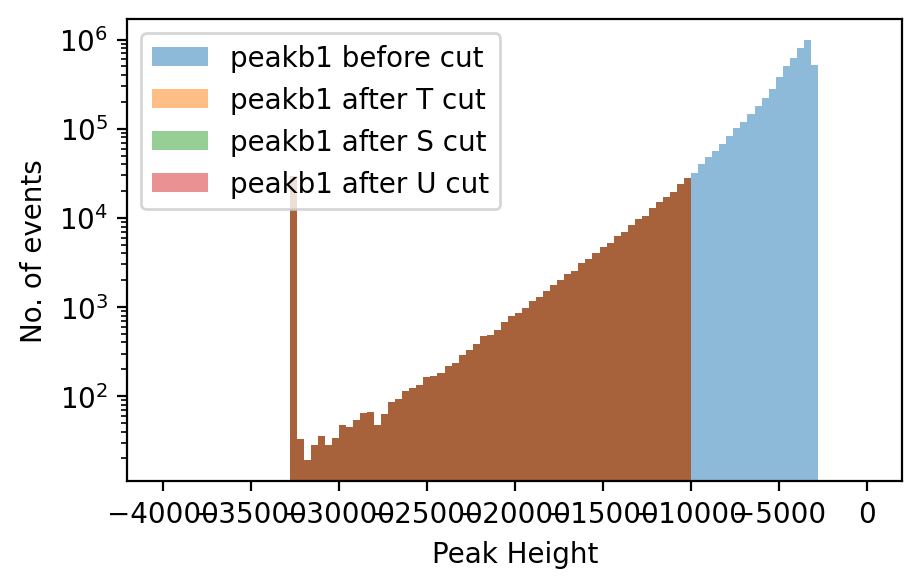

In [7]:
# Set very low (i.e. almost as if there is no cut)
PulseHeightThresholdS = -10000
PulseHeightThresholdT = -10000
PulseHeightThresholdU = -10000

DFScut3 = DFcut2.loc[(DFcut2['peakb1'] < PulseHeightThresholdS)]     
DFTcut3 = DFcut2.loc[(DFcut2['peakb1'] < PulseHeightThresholdT)]
DFUcut3 = DFcut2.loc[(DFcut2['peakb1'] < PulseHeightThresholdU)]

plt.figure(figsize=(5,3), dpi=200)

DFcut2['peakb1'].plot.hist(bins=100, alpha=0.5, label='peakb1 before cut', range=[-40000.0,0.0], logy=True)
DFTcut3['peakb1'].plot.hist(bins=100, alpha=0.5, label='peakb1 after T cut', range=[-40000.0,0.0], logy=True)
DFScut3['peakb1'].plot.hist(bins=100, alpha=0.5, label='peakb1 after S cut', range=[-40000.0,0.0], logy=True)
DFUcut3['peakb1'].plot.hist(bins=100, alpha=0.5, label='peakb1 after U cut', range=[-40000.0,0.0], logy=True)

plt.xlabel('Peak Height')
plt.ylabel('No. of events')
plt.legend()

print("Number of events before Cut3:",len(DFcut2))
print("\n")
print("Number of events after Cut3 (T):",len(DFTcut3))
print("Number of events after Cut3 (S):",len(DFScut3))

DFTcut3.head()

### Cut 4

Cut on the pulse height on the STOP counter.  The triggering of the picoscope was based on this same pulse height cut, but having taken an overnight run, we can optimise here   The relevant column name 
in the dataframes is peakb1.  The units are in ADC counts.  Remember the pulses are negative.

Number of events before Cut4 (S): 229759
Number of events before Cut4 (T): 229759


Number of events after Cut4 (S): 42011
Number of events after Cut4 (T): 42011


,delta_t_a1b1,flaga1,dtimea1,peaka1,flagb1,dtimeb1,peakb1
60,120.24,1,145.46,-6562,1,25.22,-10763
87,21.12,1,46.46,-6514,1,25.34,-12688
137,-1.42,1,23.84,-3580,1,25.26,-10245
195,218.65,1,243.77,-3934,1,25.12,-15278
218,98.04,1,123.29,-10238,1,25.25,-11863


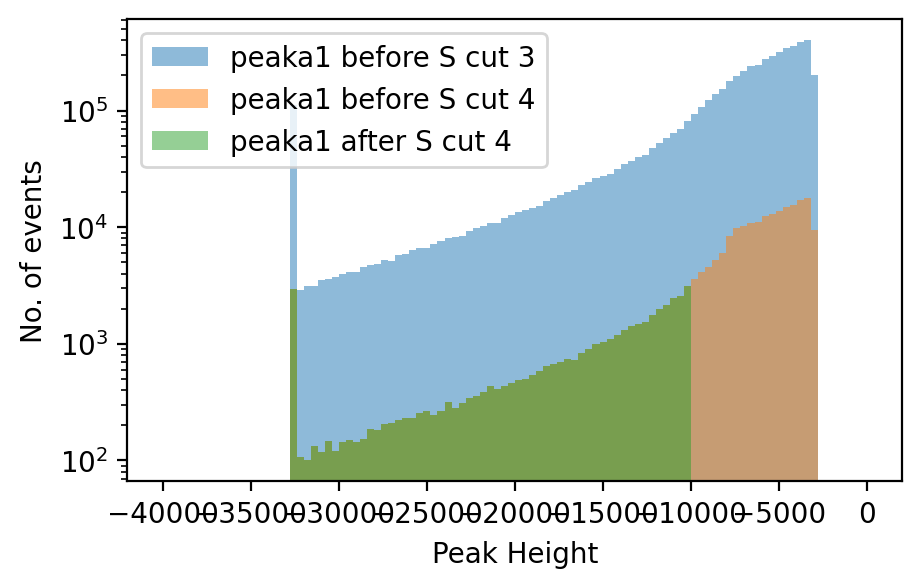

In [8]:
# Set very low (i.e. almost as if there is no cut)
# (Uses the same threshold as Cut3 here) PulseHeightThreshold = -5000

DFScut4 = DFScut3.loc[(DFScut3['peaka1'] < PulseHeightThresholdS)]     
DFTcut4 = DFTcut3.loc[(DFTcut3['peaka1'] < PulseHeightThresholdT)]
DFUcut4 = DFUcut3.loc[(DFUcut3['peaka1'] < PulseHeightThresholdU)]

plt.figure(figsize=(5,3), dpi=200)

DFcut2['peaka1'].plot.hist(bins=100, alpha=0.5, label='peaka1 before S cut 3', range=[-40000.0,0.0], logy=True)
DFScut3['peaka1'].plot.hist(bins=100, alpha=0.5, label='peaka1 before S cut 4', range=[-40000.0,0.0], logy=True)
DFScut4['peaka1'].plot.hist(bins=100, alpha=0.5, label='peaka1 after S cut 4', range=[-40000.0,0.0], logy=True)

plt.xlabel('Peak Height')
plt.ylabel('No. of events')
plt.legend()

print("Number of events before Cut4 (S):",len(DFScut3))
print("Number of events before Cut4 (T):",len(DFTcut3))
print("\n")
print("Number of events after Cut4 (S):",len(DFScut4))
print("Number of events after Cut4 (T):",len(DFTcut4))

DFTcut3.head()

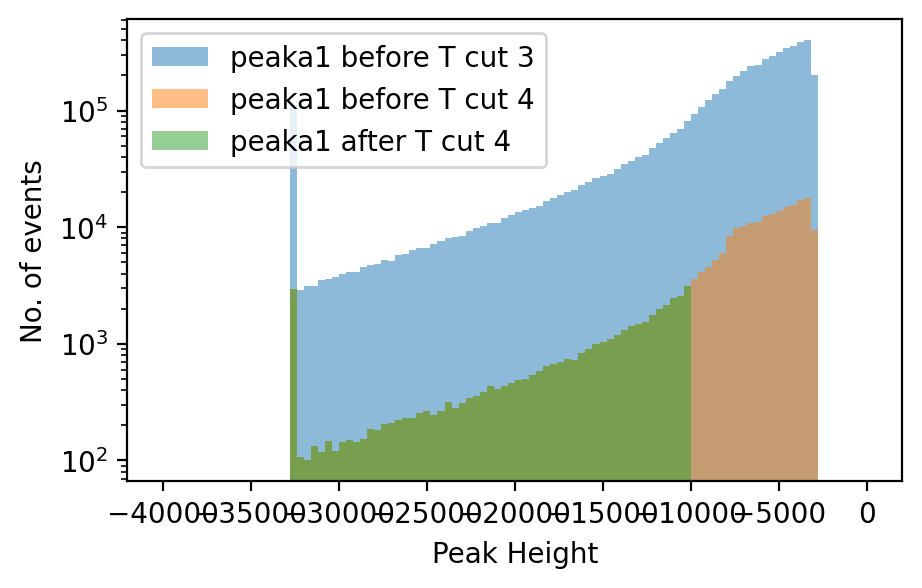

In [9]:
plt.figure(figsize=(5,3), dpi=200)

DFcut2['peaka1'].plot.hist(bins=100, alpha=0.5, label='peaka1 before T cut 3', range=[-40000.0,0.0], logy=True)
DFTcut3['peaka1'].plot.hist(bins=100, alpha=0.5, label='peaka1 before T cut 4', range=[-40000.0,0.0], logy=True)
DFTcut4['peaka1'].plot.hist(bins=100, alpha=0.5, label='peaka1 after T cut 4', range=[-40000.0,0.0], logy=True)

plt.xlabel('Peak Height')
plt.ylabel('No. of events')
plt.legend()

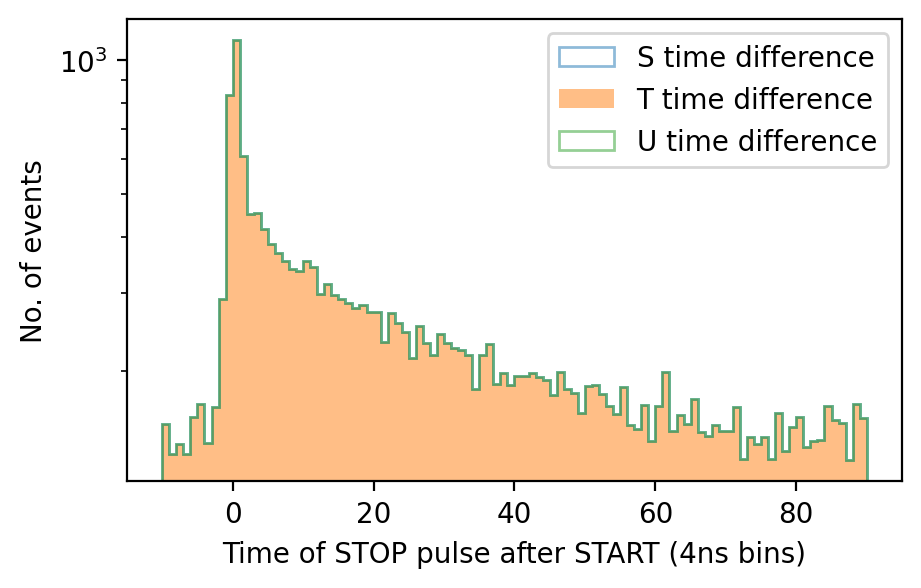

In [10]:
# and the time differences
plt.figure(figsize=(5,3), dpi=200)

DFScut4['delta_t_a1b1'].plot.hist(bins=100, range=[-10, 90], alpha=0.5, label='S time difference', logy=True, histtype = 'step')
DFTcut4['delta_t_a1b1'].plot.hist(bins=100, range=[-10, 90], alpha=0.5, label='T time difference', logy=True)
DFUcut4['delta_t_a1b1'].plot.hist(bins=100, range=[-10, 90], alpha=0.5, label='U time difference', logy=True, histtype = 'step')

plt.xlabel('Time of STOP pulse after START (4ns bins)')
plt.ylabel('No. of events')
plt.legend()

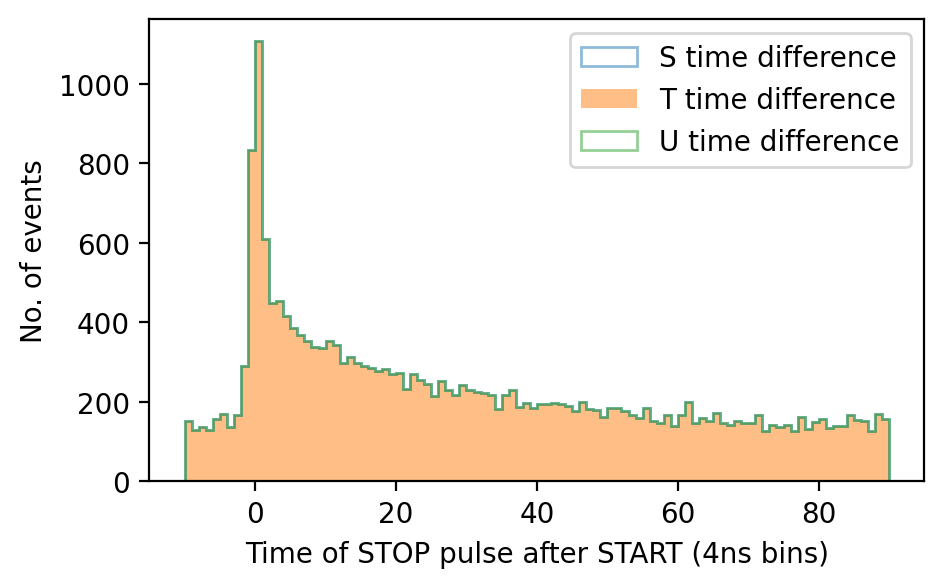

In [11]:
# Time distribution not logscale 
plt.figure(figsize=(5,3), dpi=200)

DFScut4['delta_t_a1b1'].plot.hist(bins=100, range=[-10, 90], alpha=0.5, label='S time difference', histtype = 'step')
DFTcut4['delta_t_a1b1'].plot.hist(bins=100, range=[-10, 90], alpha=0.5, label='T time difference')
DFUcut4['delta_t_a1b1'].plot.hist(bins=100, range=[-10, 90], alpha=0.5, label='U time difference', histtype = 'step')

plt.xlabel('Time of STOP pulse after START (4ns bins)')
plt.ylabel('No. of events')
plt.legend()

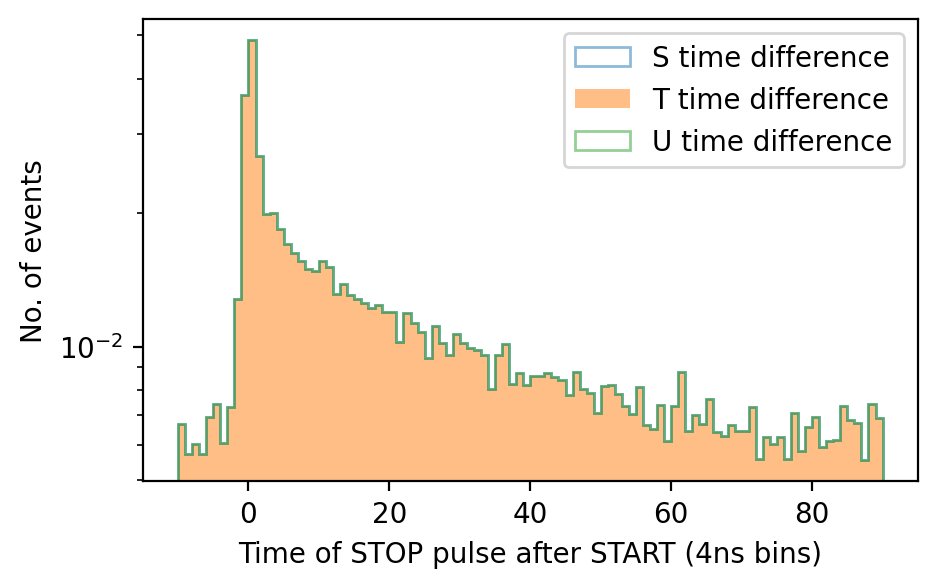

In [12]:
# Interesting to plot the normalised distributions - more subtle comparison
plt.figure(figsize=(5,3), dpi=200)

DFScut4['delta_t_a1b1'].plot.hist(bins=100, range=[-10, 90], alpha=0.5, label='S time difference', logy=True, density=True, histtype = 'step')
DFTcut4['delta_t_a1b1'].plot.hist(bins=100, range=[-10, 90], alpha=0.5, label='T time difference', logy=True, density=True)
DFUcut4['delta_t_a1b1'].plot.hist(bins=100, range=[-10, 90], alpha=0.5, label='U time difference', logy=True, density=True, histtype = 'step')

plt.xlabel('Time of STOP pulse after START (4ns bins)')
plt.ylabel('No. of events')
plt.legend()

## Fitting

This is the last step and we haven't added anything to the template yet.  See the script for some simple ways to extract the lifetime from the time distribution.  Or you can take a look at the curve_fit programs in the scipy packages.